In [8]:
import torch
import gzip
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from functions.sam_functions import batch_sample_from_class

In [2]:
embeddings = torch.load(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/embeddings_3.pt"
)

In [3]:
embeddings.shape

torch.Size([2978, 256, 64, 64])

# batched prompts

In [4]:
ground_truth_path = (
    "/Users/lisa/Documents/Master/sam-lab/ACDC/database/preprocess/ground_truth.npy.gz"
)
with gzip.open(ground_truth_path, "rb") as f:
    # Load the NumPy array from the file
    ground_truths = np.load(f)

In [16]:
ground_truth = ground_truths[0]
ground_truth = torch.tensor(ground_truth)
masks = batch_sample_from_class(2, ground_truth, 1, 15)
masks.shape

torch.Size([2, 256, 216])

tensor([[ 53, 106],
        [ 53, 107],
        [ 53, 108],
        ...,
        [105,  91],
        [106,  90],
        [106,  91]])


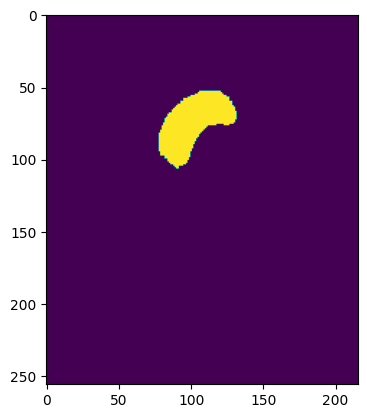

In [28]:
class_mask = torch.nonzero(ground_truth == 1, as_tuple=False)
mask = torch.zeros_like(ground_truth)
mask[class_mask[:, 0], class_mask[:, 1]] = 1
plt.imshow(mask)
# sampled_indices = class_indices[
#    np.random.choice(class_indices.shape[0], 25, replace=False)
# ]
# mask[sampled_indices[:, 0], sampled_indices[:, 1]] = 1

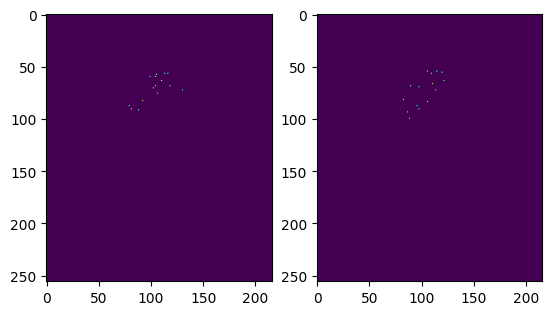

In [22]:
fig, ax = plt.subplots(1, 2)
for i, mask in enumerate(masks):
    ax[i].imshow(
        mask,
    )